<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself - with a BDT!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to apply Machine Learning in search for the Higgs boson!

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This notebook builds on HZZAnalysis.ipynb in the same folder as this notebook. HZZAnalysis.ipynb loosely follows the discovery of the Higgs boson by ATLAS https://arxiv.org/pdf/1207.7214.pdf (mostly Section 4 and 4.1)

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="HZZ_feynman.png" style="width:40%"></CENTER>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install uproot pandas numpy matplotlib sklearn --user # install required packages

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [401]:
import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks

import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

General definitions of luminosity, fraction of data used, where to access the input files

In [402]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1 # 0.9 # reduce this is you want the code to run quicker
                                                                                                                                  
tuple_path = "Input/4lep/" # local 
#tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

samples to process

In this notebook we only process the signal <span style="color:blue">H->ZZ</span> and the main background <span style="color:red">ZZ</span>, for illustration purposes. You can add data and the Z and ttbar <span style="color:red">backgrounds</span> back into after if you wish.

In [403]:
samples = {

    #'data': {
    #    'list' : ['data_A','data_B','data_C','data_D']
    #},

    #r'$Z,t\bar{t}$' : { # Z + ttbar
    #    'list' : ['Zee','Zmumu','ttbar_lep'],
    #    'color' : "#6b59d3" # purple
    #},

    'ZZ' : {
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    }

}

Define function to get data from files

In [404]:
def get_data_from_files():

    data = {}
    for s in samples:
        print('Processing '+s+' samples')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/mc_"
            if s == 'data':
                prefix = "Data/"
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root"
            if fileString != "":
                temp = read_file(fileString,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)
    
    return data

define function to calculate weight of MC event

In [405]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_LepTRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [406]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    weight *= totalWeight
    return weight

define function to calculate 4-lepton invariant mass

In [407]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

We add functions to return the individual lepton transverse momenta, in GeV

In [ ]:
def lep_pt_0(lep_pt):
    return lep_pt[0]/1000 # /1000 to go from MeV to GeV

def lep_pt_1(lep_pt):
    return lep_pt[1]/1000 # /1000 to go from MeV to GeV

def lep_pt_2(lep_pt):
    return lep_pt[2]/1000 # /1000 to go from MeV to GeV

def lep_pt_3(lep_pt):
    return lep_pt[3]/1000 # /1000 to go from MeV to GeV

All cuts are defined here

In [409]:
# cut on number of leptons
# paper: "selecting two pairs of isolated leptons"
def cut_lep_n(lep_n):
# exclamation mark (!) means "not"
# so != means "not equal to"
# throw away when number of leptons is not equal to 4 
    return lep_n != 4

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

#cut on transverse momentum of the leptons
# paper: " the second (third) lepton in pT order must satisfy pT > 15 GeV (pT > 10 GeV)"
def cut_lep_pt_012(lep_pt):
# throw away any events where lep_pt[1] < 15000 MeV
# throw away any events where lep_pt[2] < 10000 MeV
    return lep_pt[1]<15000 or lep_pt[2]<10000

All cuts are implemented here.

In this notebook, we comment out the cut on lepton pt on lines 47-49. This is so that we can optimise this cut later on.

In [410]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot.open(path)["mini"] # open the tree called mini
    numevents = uproot.numentries(path, "mini") # number of events
    for data in tree.iterate(["lep_n","lep_pt","lep_eta","lep_phi","lep_E","lep_charge","lep_type","lep_ptcone30",
                            "lep_etcone20", # add more variables here if you make cuts on them 
                            "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON",
                            "scaleFactor_LepTRIGGER"], # variables to calculate Monte Carlo weight
                           entrysteps=2500000, # number of events in a batch to process
                           outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                           entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        print('\t initial number of events:\t\t\t',nIn)

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)
            # incorporate the cross-section weight into the total weight
            data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)
            
        # drop the columns we don't need anymore from the dataframe
        data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_LepTRIGGER"], 
                  axis=1, inplace=True)

        # cut on number of leptons using the function cut_lep_n defined above
        fail = data[ np.vectorize(cut_lep_n)(data.lep_n)].index
        data.drop(fail, inplace=True)
        print('\t after requiring 4 leptons:\t\t\t',len(data.index))

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)
        print('\t after requiring zero net charge:\t\t',len(data.index))

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)
        print('\t after requiring lepton pairs of same type:\t',len(data.index))

        #cut on the transverse momentum of the leptons using the function cut_lep_pt_012 defined above
        #fail =data[ np.vectorize(cut_lep_pt_012)(data.lep_pt)].index
        #data.drop(fail,inplace=True)
        #print('\t after requirements on lepton pt:\t\t',len(data.index))

        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        
        # return the individual lepton transverse momenta in GeV
        #data['lep_pt_0'] = np.vectorize(lep_pt_0)(data.lep_pt)
        data['lep_pt_1'] = np.vectorize(lep_pt_1)(data.lep_pt)
        data['lep_pt_2'] = np.vectorize(lep_pt_2)(data.lep_pt)
        #data['lep_pt_3'] = np.vectorize(lep_pt_3)(data.lep_pt)

        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['lep_pt','lep_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

This is where the processing happens

In [265]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing ZZ samples
	Processing: llll
	 initial number of events:			 554279
	 after requiring 4 leptons:			 550307
	 after requiring zero net charge:		 535288
	 after requiring lepton pairs of same type:	 520982
		 nIn: 554279,	 nOut: 	520982	 in 88.5s
Processing $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ samples
	Processing: ggH125_ZZ4lep
	 initial number of events:			 164716
	 after requiring 4 leptons:			 163781
	 after requiring zero net charge:		 161242
	 after requiring lepton pairs of same type:	 160824
		 nIn: 164716,	 nOut: 	160824	 in 26.3s
	Processing: VBFH125_ZZ4lep
	 initial number of events:			 191126
	 after requiring 4 leptons:			 189961
	 after requiring zero net charge:		 186658
	 after requiring lepton pairs of same type:	 186092
		 nIn: 191126,	 nOut: 	186092	 in 24.1s
	Processing: WH125_ZZ4lep
	 initial number of events:			 15379
	 after requiring 4 leptons:			 12732
	 after requiring zero net charge:		 10325
	 after requiring lepton pairs of same type:	 906

## Make a change to plotting
If you only want a make a change in plotting: Cell -> Run All Below

In [411]:
mllll = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':5, # width of each histogram bin
    'num_bins':34, # number of histogram bins
    'xrange_min':80, # minimum on x-axis
    'xlabel':r'$\mathrm{m_{4l}}$ [GeV]', # x-axis label

    # change aesthetic parameters if you want
    'y_label_x_position':-0.09, # 0.09 to the left of y axis
    'linear_top_margin':1.4 # to decrease the separation between data and the top of the figure, pick a number closer to 1
}

hist_dict = {'mllll':mllll} # add a histogram here if you want it plotted

Define function to plot the data

In [412]:
def plot_data(data):

    plot_label = r'$H \rightarrow ZZ^* \rightarrow \ell\ell\ell\ell$' # label to write on the plot
    signal_label = 'Signal ($m_H=125$ GeV)' # signal label in legend
    signal = r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)
    lumi_used = str(lumi*fraction) # luminosity to write on the plot

    for x_variable,hist in hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
        h_y_label_x_position = hist['y_label_x_position'] # get the x-position of the y-axis label defined in the cell above
        h_linear_top_margin = hist['linear_top_margin'] # to decrease the separation between data and the top of the figure, pick a number closer to 1
    
        bins = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres

        data_x,_ = np.histogram( data['data'][x_variable].values, bins=bins ) # histogram the data
        data_x_errors = np.sqrt( data_x ) # statistical error on the data

        signal_x = data[signal][x_variable].values # histogram the signal
        signal_weights = data[signal].totalWeight.values # get the weights of the signal events
        signal_color = samples[signal]['color'] # get the colour for the signal bar
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries
        mc_weights = [] # define list to hold the Monte Carlo weights
        mc_colors = [] # define list to hold the colors of the Monte Carlo bars
        mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars
        mc_x_tot = np.zeros( len(bin_centres) ) # define array of length bin_centres to hold the sum of MC bars

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x.append( data[s][x_variable].values ) # append to the list of Monte Carlo histogram entries
                mc_weights.append( data[s].totalWeight.values ) # append to the list of Monte Carlo weights
                mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
                mc_labels.append( s ) # append to the list of Monte Carlo legend labels
                mc_x_heights,_ = np.histogram(data[s][x_variable].values, bins=bins,
                                              weights=data[s].totalWeight.values ) # histogram the current sample
                mc_x_tot = np.add( mc_x_tot, mc_x_heights ) # add to the array holding the total MC y-axis value
    
        mc_x_err = np.sqrt( mc_x_tot ) # statistical error on the Monte Carlo bars
    
    
        # *************
        # Main plot 
        # *************
        plt.clf() # clear figure
        plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
        main_axes = plt.gca() # get current axes
        # plot the data points
        main_axes.errorbar( x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data' ) 
        # plot the Monte Carlo bars
        mc_heights = main_axes.hist(mc_x, bins=bins, weights=mc_weights, stacked=True, color=mc_colors, 
                                    label=mc_labels )
        # plot the signal bar
        main_axes.hist(signal_x, bins=bins, bottom=mc_x_tot, weights=signal_weights, color=signal_color,
                       label=signal )
        # plot the statistical uncertainty
        main_axes.bar(bin_centres, # x
                      2*mc_x_err, # heights
                      alpha=0.5, # half transparency
                      bottom=mc_x_tot-mc_x_err, color='none', hatch="////", width=h_bin_width, 
                      label='Stat. Unc.' )
        
        main_axes.set_xlim( left=h_xrange_min, right=bins[-1] ) # set the x-limit of the main axes
        main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) # separation of x axis minor ticks
        # set the axis tick parameters for the main axes
        main_axes.tick_params(which='both', # ticks on both x and y axes
                              direction='in', # Put ticks inside and outside the axes
                              top=True, # draw ticks on the top axis
                              labeltop=False, # don't draw tick labels on top axis
                              labelbottom=False, # don't draw tick labels on bottom axis
                              right=True, # draw ticks on right axis
                              labelright=False ) # don't draw tick labels on right axis
        if len( h_xlabel.split('[') ) > 1: # if x-axis has units
            y_units = ' '+h_xlabel[h_xlabel.find("[")+1:h_xlabel.find("]")]
        else: y_units = '' # if x-axis is unitless
        main_axes.set_ylabel('Events / '+str(h_bin_width)+y_units, fontname='sans-serif',
                             horizontalalignment='right', y=1.0, fontsize=11 ) # write y-axis label for main axes
        # set y-axis limits for main axes
        main_axes.set_ylim( bottom=0, top=(np.amax(data_x)+math.sqrt(np.amax(data_x)))*h_linear_top_margin )
        main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) # add minor ticks on y-axis for main axes
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.97, # y
                 'ATLAS Open Data', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.9, # y
                 'for education', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', style='italic',
                 fontsize=8 ) 
        # Add energy and luminosity
        plt.text(0.05, # x
                 0.86, # y
                 '$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+'$\,\mathrm{fb}^{-1}$', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' ) 
        # Add a label for the analysis carried out
        plt.text(0.05, # x
                 0.78, # y
                 plot_label, # text 
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' )
    
        # Create new legend handles but use the colors from the existing ones 
        handles, labels = main_axes.get_legend_handles_labels()
    
        # specify order within legend
        new_handles = [ handles[labels.index('Data')] ] # first entry in legend is 'Data'
        new_labels = ['Data']
        for s in reversed( list( samples.keys() ) ): # loop over samples names
            if s not in ['data', signal]: # if not data nor signal
                new_handles.append( handles[labels.index(s)] ) # next entries in legend are the Background MC
                new_labels.append( s )
        new_handles.append( handles[labels.index(signal)] ) # next entry in legend is signal
        new_labels.append( signal_label )
        new_handles.append( handles[labels.index('Stat. Unc.')] ) # next entry in legend is uncertainty
        new_labels.append( 'Stat. Unc.' )
        
        # draw the legend
        main_axes.legend( handles=new_handles, labels=new_labels, frameon=False ) # no box around the legend
    
    
        # *************
        # Data/MC ratio 
        # *************
        plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
        ratio_axes = plt.gca() # get current axes
        ratio_axes.errorbar( x=bin_centres, y=data_x/mc_x_tot, yerr=data_x_errors/mc_x_tot, fmt='ko' )
        # draw uncertainty band on ratio axes
        ratio_axes.bar(bin_centres, # x
                       2*mc_x_err/mc_x_tot, # heights 
                       alpha=0.5, # half transparency
                       bottom=1-mc_x_err/mc_x_tot, color='none', hatch="////", width=h_bin_width )
        # draw horizontal line for Data/MC = 1
        ratio_axes.plot(bins, # x
                        np.ones(len(bins)), # y
                        color='k') # 'k' means black
        ratio_axes.set_xlim( left=h_xrange_min, right=bins[-1] ) # set the x-axis limits on the ratio axes
        ratio_axes.xaxis.set_minor_locator( AutoMinorLocator() ) # separation of x-axis minor ticks
        ratio_axes.xaxis.set_label_coords(0.9,-0.2) # (x,y) of x axis label # 0.2 down from x-axis
        ratio_axes.set_xlabel( h_xlabel, fontname='sans-serif', fontsize=11) # x-axis label
        # set the tick parameters for the ratio axes
        ratio_axes.tick_params(which='both', # ticks on both x and y axes
                             direction='in', # Put ticks inside and outside the axes
                             top=True, # draw ticks on the top axis
                             labeltop=False, # don't draw tick labels on top axis
                             right=True, # draw ticks on right axis
                             labelright=False ) # don't draw tick labels on right axis
        ratio_axes.set_ylim( bottom=0, top=2.5 ) # set the y-axis limits on the ratio axes
        ratio_axes.set_yticks( [0,1,2] ) # set the values to be labelled on the y-axis
        ratio_axes.yaxis.set_minor_locator( AutoMinorLocator() ) # separation of x-axis minor ticks
        ratio_axes.set_ylabel( 'Data/SM', fontname='sans-serif', x=1, fontsize=11 ) # y-axis label on the ratio axes
        
        
        # Generic features for both plots
        main_axes.yaxis.set_label_coords( h_y_label_x_position, 1 ) # x,y coordinates of the y-axis label on the main axes
        ratio_axes.yaxis.set_label_coords( h_y_label_x_position, 0.5 ) # x,y coordinates of the y-axis label on the ratio axes
    
        plt.savefig( "HZZ_"+x_variable+".pdf", bbox_inches='tight' ) # save the plot
        plt.show()
    
    return

Call the function to plot the data.

In this notebook, we comment out the plotting of the Data vs MC comparison, since plotting a Data vs MC comparison doesn't make much sense without Data! If you do process the real data, you can uncomment this back in if you want.

In [413]:
#plot_data(data)

Here we define histograms for the variables that we'll look to optimise

In [494]:
lep_pt_2 = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':13, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[2] [GeV]', # x-axis label
}

lep_pt_1 = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':1, # width of each histogram bin
    'num_bins':28, # number of histogram bins
    'xrange_min':7, # minimum on x-axis
    'xlabel':r'$lep\_pt$[1] [GeV]', # x-axis label
}

SoverB_hist_dict = {'lep_pt_2':lep_pt_2,'lep_pt_1':lep_pt_1} 
# add a histogram here if you want it plotted

Here we define a function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

In [495]:
def plot_SoverB(data):

    plot_label = r'$H \rightarrow ZZ^* \rightarrow \ell\ell\ell\ell$' # label to write on the plot
    signal = r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)
    lumi_used = str(lumi*fraction) # luminosity to write on the plot

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bins = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable].values # histogram the signal
        signal_weights = data[signal].totalWeight.values # get the weights of the signal events
        signal_color = samples[signal]['color'] # get the colour for the signal bar
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries
        mc_weights = [] # define list to hold the Monte Carlo weights
        mc_x_tot = np.zeros( len(bin_centres) ) # define array of length bin_centres to hold the sum of MC bars

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable].values ] # append to the list of Monte Carlo histogram entries
                mc_weights = [*mc_weights, *data[s].totalWeight.values ] # append to the list of Monte Carlo weights
                mc_x_heights,_ = np.histogram(data[s][x_variable].values, bins=bins,
                                              weights=data[s].totalWeight.values ) # histogram the current sample
                mc_x_tot = np.add( mc_x_tot, mc_x_heights ) # add to the array holding the total MC y-axis value
    
        mc_x_err = np.sqrt( mc_x_tot ) # statistical error on the Monte Carlo bars
    
    
        # *************
        # Signal and background distributions
        # *************
        plt.clf() # clear figure
        plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
        main_axes = plt.gca() # get current axes
 
        mc_heights = main_axes.hist(mc_x,bins=bins,color='r', label='Total background',histtype='step',density=True,weights=mc_weights)
        signal_heights = main_axes.hist(signal_x,bins=bins,color=signal_color,label=signal,histtype='step',density=True,linestyle='--',weights=signal_weights)
        
        main_axes.set_xlim( left=h_xrange_min, right=bins[-1] ) # set the x-limit of the main axes
        main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) # separation of x axis minor ticks
        # set the axis tick parameters for the main axes
        main_axes.tick_params(which='both', # ticks on both x and y axes
                              direction='in', # Put ticks inside and outside the axes
                              top=True, # draw ticks on the top axis
                              labeltop=False, # don't draw tick labels on top axis
                              right=True, # draw ticks on right axis
                              labelright=False ) # don't draw tick labels on right axis
        main_axes.set_ylabel('Arbitrary units', fontname='sans-serif',
                             horizontalalignment='right', y=1.0, fontsize=11 ) # write y-axis label for main axes
        # set y-axis limits for main axes
        main_axes.set_ylim( bottom=0, top=max(signal_heights[0])*1.3 )
        main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) # add minor ticks on y-axis for main axes
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.97, # y
                 'ATLAS Open Data', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.9, # y
                 'for education', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', style='italic',
                 fontsize=8 ) 
        # Add energy and luminosity
        plt.text(0.05, # x
                 0.86, # y
                 '$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+'$\,\mathrm{fb}^{-1}$', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' ) 
        # Add a label for the analysis carried out
        plt.text(0.05, # x
                 0.78, # y
                 plot_label, # text 
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' )
        plt.title('Signal and background '+x_variable+' distributions', family='sans-serif')
    
        
        # draw the legend
        main_axes.legend( frameon=False ) # no box around the legend
        
        
        # Generic features for both plots
        main_axes.set_xlabel( h_xlabel, fontname='sans-serif', fontsize=11) # x-axis label
    
        plt.savefig( "HZZ_"+x_variable+".pdf", bbox_inches='tight' ) # save the plot
        plt.show()
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure()
        SoverB = []
        for cut_value in bins:
            signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight.values)
            background_weights_passing_cut = 0
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight.values)
            if background_weights_passing_cut!=0:
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value
                SoverB.append(SoverB_percent)
        
        plt.clf() # clear figure
        plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
        main_axes = plt.gca() # get current axes
        
        main_axes.plot( bins[:len(SoverB)], SoverB ) # plot the data points
        
        main_axes.set_xlim( left=h_xrange_min, right=bins[-1] ) # set the x-limit of the main axes
        main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) # separation of x axis minor ticks
        # set the axis tick parameters for the main axes
        main_axes.tick_params(which='both', # ticks on both x and y axes
                              direction='in', # Put ticks inside and outside the axes
                              top=True, # draw ticks on the top axis
                              labeltop=False, # don't draw tick labels on top axis
                              right=True, # draw ticks on right axis
                              labelright=False ) # don't draw tick labels on right axis
        main_axes.set_ylabel(r'S/B (%)', fontname='sans-serif',
                             horizontalalignment='right', y=1.0, fontsize=11 ) # write y-axis label for main axes
        main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) # add minor ticks on y-axis for main axes
        
        # Add text 'ATLAS Open Data' on plot
        plt.text(0.05, # x
                 0.3, # y
                 'ATLAS Open Data', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', fontsize=13 ) 
        # Add text 'for education' on plot
        plt.text(0.05, # x
                 0.23, # y
                 'for education', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif', style='italic',
                 fontsize=8 ) 
        # Add energy and luminosity
        plt.text(0.05, # x
                 0.19, # y
                 '$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+'$\,\mathrm{fb}^{-1}$', # text
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' ) 
        # Add a label for the analysis carried out
        plt.text(0.05, # x
                 0.11, # y
                 plot_label, # text 
                 transform=main_axes.transAxes, # coordinate system used is that of main_axes
                 horizontalalignment='left', verticalalignment='top', family='sans-serif' )
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        
        # Generic features
        main_axes.set_xlabel( h_xlabel, fontname='sans-serif', fontsize=11) # x-axis label
    
        plt.savefig( "HZZ_"+x_variable+"_SoverB.pdf", bbox_inches='tight' ) # save the plot
        plt.show()
    
    return

Here we call our function to illustrate the optimum cut value on individual variables, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

Let's talk through the lep_pt_2 plots.
1. Imagine placing a cut at 7 GeV in the distributions of <span style="color:blue">signal</span> and <span style="color:red">background</span> (1st plot). This means keeping all events above 7 GeV in the <span style="color:blue">signal</span> and <span style="color:red">background</span> histograms. 
2. We then take the ratio of the number of <span style="color:blue">signal</span> events that pass this cut, to the number of <span style="color:red">background</span> events that pass this cut. This gives us a starting value for S/B (2nd plot). 
3. We then increase this cut value to 8 GeV, 9 GeV, 10 GeV, 11 GeV, 12 GeV. Cuts at these values are throwing away more <span style="color:red">background</span> than <span style="color:blue">signal</span>, so S/B increases. 
4. There comes a point around 13 GeV where we start throwing away too much <span style="color:blue">signal</span>, thus S/B starts to decrease. 
5. Our goal is to find the maximum in S/B, and place the cut there.

The same logic applies to lep_pt_1.

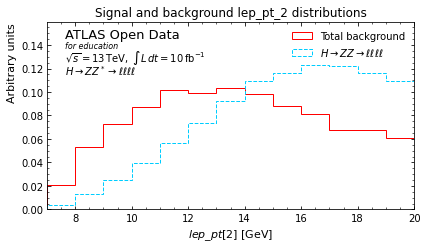

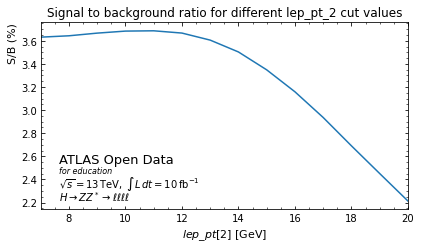

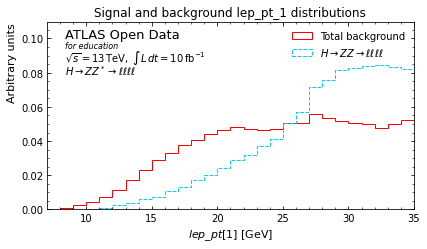

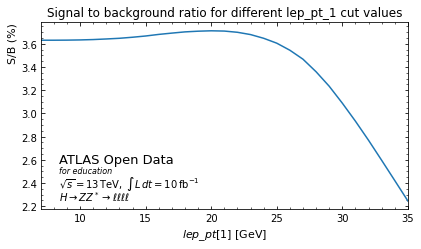

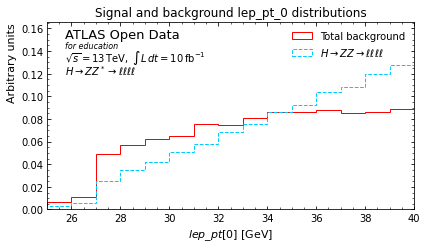

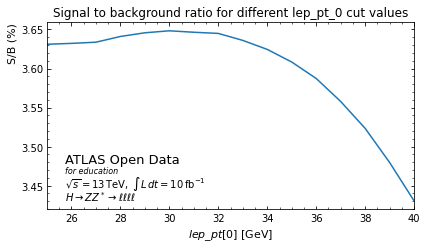

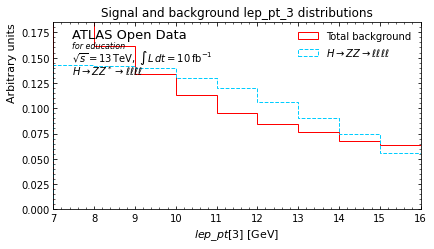

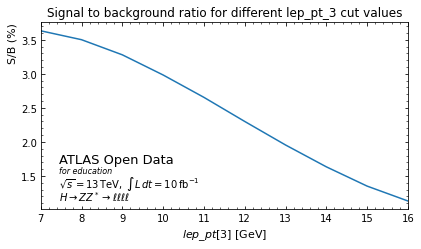

In [496]:
plot_SoverB(data)

## BDT

Choose variables for use in the BDT

In [444]:
data_for_BDT = {} # define empty dictionary to hold dataframes that will be used to train the BDT
for key in data: # loop over the different keys in the dictionary of dataframes
    data_for_BDT[key] = data[key][['lep_pt_1','lep_pt_2']].copy()
data_for_BDT

{'ZZ':           lep_pt_1   lep_pt_2
 entry                        
 0        61.677957  48.666441
 1        41.498750  18.562252
 2        78.250461  56.973090
 3        26.851668  13.466778
 4        98.566398  74.528453
 ...            ...        ...
 554273   51.921211  50.100371
 554275   48.862410  39.796707
 554276  102.871875  54.995215
 554277   31.902018  20.184078
 554278   49.681914  11.938686
 
 [520982 rows x 2 columns],
 '$H \\rightarrow ZZ \\rightarrow \\ell\\ell\\ell\\ell$':         lep_pt_1   lep_pt_2
 entry                      
 0      41.248570  16.397670
 1      40.307168  16.133789
 2      27.313271  20.035949
 3      27.845740  17.726541
 4      53.367754  25.596689
 ...          ...        ...
 14476  36.749836  28.510283
 14478  31.143605  26.637549
 14480  73.832656  13.217979
 14481  36.526355  15.398255
 14483  27.985783  20.745455
 
 [366764 rows x 2 columns]}

 Organise data ready for the BDT

In [445]:
# for sklearn data is usually organised                                                                                                                                           
# into one 2D array of shape (n_samples x n_features)                                                                                                                             
# containing all the data and one array of categories                                                                                                                             
# of length n_samples  

all_MC = [] # define empty list that will contain all features for the MC
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!='data': # only MC should pass this
        all_MC.append(data_for_BDT[key]) # append the MC dataframe to the list containing all MC features
X = np.concatenate(all_MC) # concatenate the list of MC dataframes into a single 2D array of features, called X

all_y = [] # define empty list that will contain labels whether an event in signal or background
for key in data: # loop over the different keys in the dictionary of dataframes
    if key!=r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' and key!='data': # only background MC should pass this
        all_y.append(np.zeros(data_for_BDT[key].shape[0])) # background events are labelled with 0
all_y.append(np.ones(data_for_BDT[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'].shape[0])) # signal events are labelled with 1
y = np.concatenate(all_y) # concatenate the list of lables into a single 1D array of labels, called y

### The Training and Testing split
One of the first things to do is split your data into a training and testing set. This will split your data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of <span style="color:orange">X</span> for training and the last 33% for testing. This is particularly important in cases where you load all <span style="color:blue">signal</span> events first and then the <span style="color:red">background</span> events.

Here we split our data into two independent samples twice. The first split is to create a development and a evaluation set. All development and performance evaluation will be done with the development set. Once the hyper-parameters and other settings are frozen we can use the evaluation set to get an unbiased estimate of the performance.

The development set is further split into a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

In [446]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                                test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                    test_size=0.33, random_state=492)

### Training Decision Trees
Here we set several hyper-parameters to non default values.

After instantiating our <span style="color:orange">AdaBoostClassifier</span>, call the <span style="color:orange">fit()</span> method with the training sample as an argument. This will train the tree, now we are ready to evaluate the performance on the held out testing set.

In [447]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=3)
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME',
                        n_estimators=800,
                        learning_rate=0.5)

start = time.time() # time at start of BDT fit
bdt.fit(X_train, y_train) 
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)

Time taken to fit BDT: 1258.9s


The <span style="color:orange">fit()</span> method returns the trained classifier. When printed out all the hyper-parameters are listed.

### Assessing a Classifier's Performance
Next let's create a quick report on how well our classifier is doing. It is important to make sure you use samples not seen by the classifier to get an unbiased estimate of its performance.

In [448]:
from sklearn.metrics import classification_report, roc_auc_score
y_predicted = bdt.predict(X_test)
print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    bdt.decision_function(X_test))))

              precision    recall  f1-score   support

  background       0.81      0.77      0.79    114988
      signal       0.69      0.74      0.72     81293

    accuracy                           0.76    196281
   macro avg       0.75      0.75      0.75    196281
weighted avg       0.76      0.76      0.76    196281

Area under ROC curve for test data: 0.8174


To illustrate that point, here's the same performance metrics evaluated on the training set instead. The estimates of the performance are more optimistic than on an unseen set of events.

In [449]:
y_predicted = bdt.predict(X_train)
print (classification_report(y_train, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for training data: %.4f"%(roc_auc_score(y_train,
                                                    bdt.decision_function(X_train))))

              precision    recall  f1-score   support

  background       0.81      0.77      0.79    234409
      signal       0.69      0.74      0.71    164099

    accuracy                           0.76    398508
   macro avg       0.75      0.75      0.75    398508
weighted avg       0.76      0.76      0.76    398508

Area under ROC curve for training data: 0.8183


### ROC curve for BDT
Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.

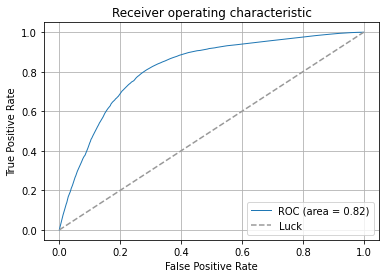

In [450]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### BDT Overtraining Check
Comparing the BDT's output distribution for the training and testing set is a popular way in HEP to check for overtraining. The <span style="color:orange">compare_train_test()</span> method will plot the shape of the BDT's decision function for each class, as well as overlaying it with the decision function in the training set.

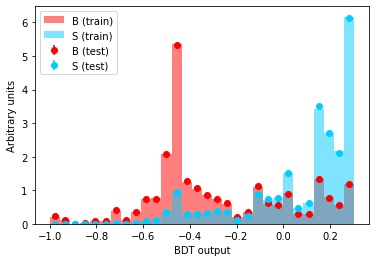

In [451]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y<0.5]).ravel()
        d2 = clf.decision_function(X[y>0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')
    plt.hist(decisions[1],
             color=samples[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']['color'], alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')

    hist_background, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist_background)
    err_background = np.sqrt(hist_background * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', c='r', label='B (test)')
    
    hist_signal, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[3]) / sum(hist_signal)
    err_signal = np.sqrt(hist_signal * scale) / scale
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', c=samples[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']['color'], label='S (test)')
    
    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)

Here we get the BDT's decision function for every event that was processed at the begininning (so could be data, <span style="color:blue">signal</span>, <span style="color:red">background</span>...). The higher the decision function, the more the BDT thinks that event looks like <span style="color:blue">signal</span>.

In [452]:
y_predicted = bdt.decision_function(X)
y_predicted

array([-0.46583128,  0.29368522, -0.48595961, ..., -0.02694487,
        0.28653224,  0.19540274])

In this cell we save the BDT output to our dataframes.

In [453]:
cumulative_events = 0
for key in data:
    data[key]['BDT_output'] = y_predicted[cumulative_events:cumulative_events+len(data[key])]
    cumulative_events += len(data[key])
    print(data[key]['BDT_output'])

entry
0        -0.465831
1         0.293685
2        -0.485960
3         0.049690
4        -0.561013
            ...   
554273   -0.468304
554275   -0.460652
554276   -0.572121
554277    0.261686
554278    0.273116
Name: BDT_output, Length: 520982, dtype: float64
entry
0        0.284910
1        0.295282
2        0.174285
3        0.195403
4       -0.091694
           ...   
14476    0.136829
14478    0.171174
14480   -0.026945
14481    0.286532
14483    0.195403
Name: BDT_output, Length: 366764, dtype: float64


Here we define parameters to plot the BDT output

In [486]:
BDT_output = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':14, # number of histogram bins
    'xrange_min':-1, # minimum on x-axis
    'xlabel':'BDT output', # x-axis label
}

SoverB_hist_dict = {'BDT_output':BDT_output}

Here we call the function defined above to to illustrate the optimum cut value on BDT output, based on <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio.

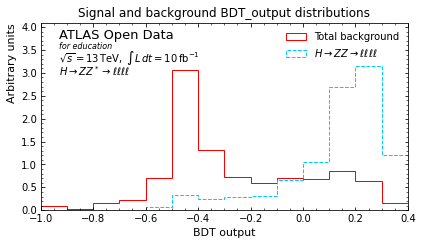

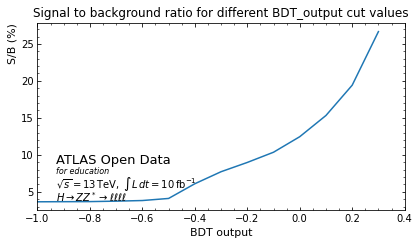

In [487]:
plot_SoverB(data)

Putting everything into a BDT means we only have 1 variable to optimise. The <span style="color:blue">signal</span> and <span style="color:red">background</span> distributions are separated much better when looking at BDT output, compared to individual variables. Cutting on BDT output also achieves much higher S/B values than on individual variables.

Hopefully you've enjoyed this discussion on optimising for <span style="color:blue">signal</span> to <span style="color:red">background</span> ratio, and in particular how a BDT can be used to facilitate this.

If you want to go further, there are a number of things you could try: 
* Increase the fraction of events that are processed, at the top of this notebook.
* Add in the Z and ttbar <span style="color:red">backgrounds</span>. Try adding them separately first, then see how things look with both added.
* Add some more variables into the BDT. Add them in one at a time, rather than all at once, because adding a variable could decrease BDT performance, due to anti-correlation. For some ideas of variables, you can look at the Higgs discovery paper Section 4 and 4.1 https://arxiv.org/pdf/1207.7214.pdf
* Add in real data and see whether the BDT output distributions in data and MC match.
* Modify some BDT hyper-parameters

With each change, keep an eye on the:
* total area under the ROC curve, 
* separation between <span style="color:blue">signal</span> and <span style="color:red">background</span> in the BDT output distribution
* S/B scores that can be achieved